# HW 3
## Tim Demetriades
### AAI 646 - B - Hong Man
4/16/2022

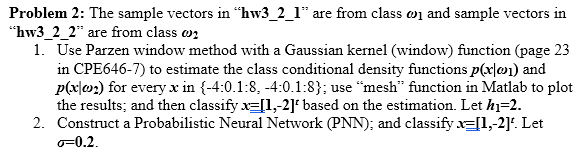

### Part 1

First the data is loaded in and some things are initialized.

In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from math import sqrt, pi, e
%matplotlib inline

In [2]:
hw3_2_1 = io.loadmat('hw3.mat')['hw3_2_1']
hw3_2_2 = io.loadmat('hw3.mat')['hw3_2_2']

In [3]:
h_1 = 2
n = len(hw3_2_1.T)    # 100

In [4]:
h_n = h_1 / sqrt(n)    # 0.2

This vector will be used to create a mesh grid so that we can scan over every x in the interval.

In [5]:
x_vector = np.linspace(-4, 8, 121)    # vector of evenly spaced nums from -4 to 8

In [6]:
X, Y = np.meshgrid(x_vector, x_vector)

In [7]:
x = np.vstack((x_vector, x_vector)).T    # 2D array of shape 100x2

The function below is used to calculate the euclidean distance between 2 vectors, which is needed for calculating the density in the next step (the 'x - xi' part).

In [9]:
def dist(x,y):   
    return sqrt(np.sum((x-y)**2))    # returns euclidean distance between 2 vectors

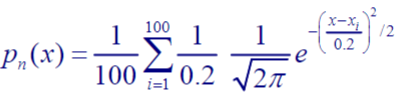

This function calculates the density for a given sample using the formula above. It will go over all the samples and do a summation, then divide by the number of samples.

In [10]:
def calc_density(x, samples):
    p_n = 0
    for i in range(n):
        p_n += (1 / h_n) * (1 / sqrt(2 * pi)) * e ** (-(((dist(x, samples.T[i])) / h_n) ** 2) / 2)
    p_n *= 1 / n
    return p_n

In [11]:
# Initialize density matrices
density_matrix_1 = np.zeros((len(x), len(x))) 
density_matrix_2 = np.zeros((len(x), len(x))) 

Here we will use the formula above to calculate the class conditional density for all of the points on the interval -4 to 8 (121 x 121 = 14,641 total points) for each of the 2 classes.

In [12]:
# Class 1
for i in range(len(x)):
    for j in range(len(x)):
        density = calc_density(np.array((x[i, 0], x[j, 1])), hw3_2_1)
        density_matrix_1[i, j] = density

# Class 2
for i in range(len(x)):
    for j in range(len(x)):
        density = calc_density(np.array((x[i, 0], x[j, 1])), hw3_2_2)
        density_matrix_2[i, j] = density

Below are the 2 density matrices obtained, each of shape 121x121.

In [13]:
density_matrix_1

array([[5.35269392e-014, 4.84943941e-013, 3.42166151e-012, ...,
        2.82550908e-147, 1.97747768e-152, 1.07783642e-157],
       [7.84933453e-013, 7.11134856e-012, 5.01761659e-011, ...,
        1.16548680e-149, 8.15675232e-155, 4.44583755e-160],
       [8.96436738e-012, 8.12154723e-011, 5.73039133e-010, ...,
        1.08954656e-149, 7.59638134e-155, 4.12471670e-160],
       ...,
       [1.71503550e-036, 9.39088346e-036, 4.00466477e-035, ...,
        4.93922024e-126, 3.61446608e-130, 2.05994817e-134],
       [3.78691408e-039, 2.07357041e-038, 8.84256993e-038, ...,
        2.80678628e-129, 2.05397478e-133, 1.17059657e-137],
       [6.51214658e-042, 3.56580429e-041, 1.52060782e-040, ...,
        1.24218613e-132, 9.09017907e-137, 5.18065389e-141]])

In [14]:
density_matrix_2

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.92560939e-210, 1.35859677e-213, 4.91350263e-217],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.88517595e-204, 8.75439477e-208, 3.16611542e-211],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        9.46049412e-199, 4.39327163e-202, 1.58887112e-205],
       ...,
       [8.82460772e-199, 6.01162237e-193, 3.18943939e-187, ...,
        5.37289663e-050, 7.36563563e-052, 7.90015208e-054],
       [1.16830852e-201, 7.95891430e-196, 4.22256643e-190, ...,
        1.07319383e-052, 1.43249065e-054, 1.53139863e-056],
       [1.20460888e-204, 8.20620467e-199, 4.35376523e-193, ...,
        1.95832753e-055, 2.21525115e-057, 2.31759904e-059]])

In order to plot the 3D data as a surface we will save the data as a `.mat` file and load it into MATLAB, and then from there use the mesh function to graph it.

In [15]:
io.savemat('hw3_2_1_results.mat', dict(x = X, y = Y, z1 = density_matrix_1, z2 = density_matrix_2))

**Class 1 Density**

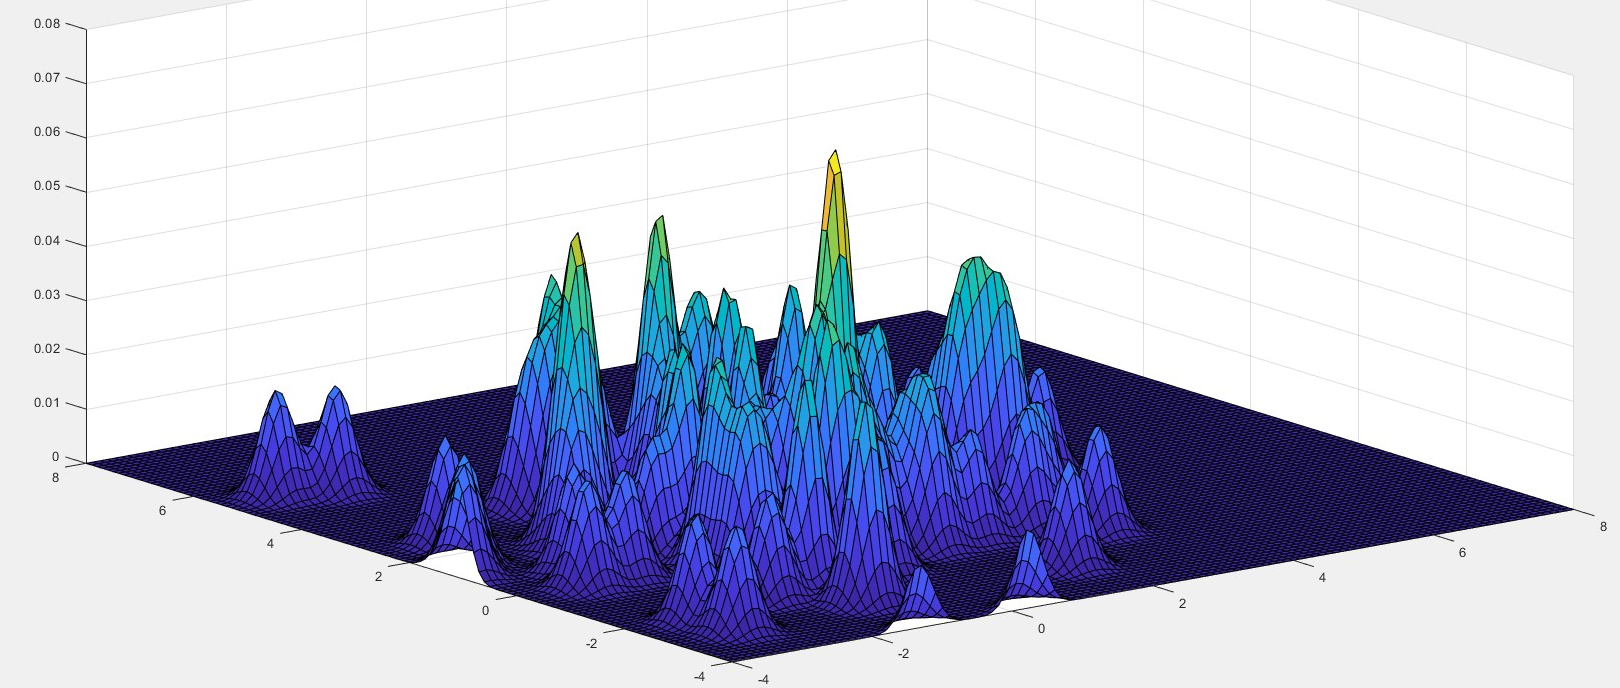

**Class 2 Density**

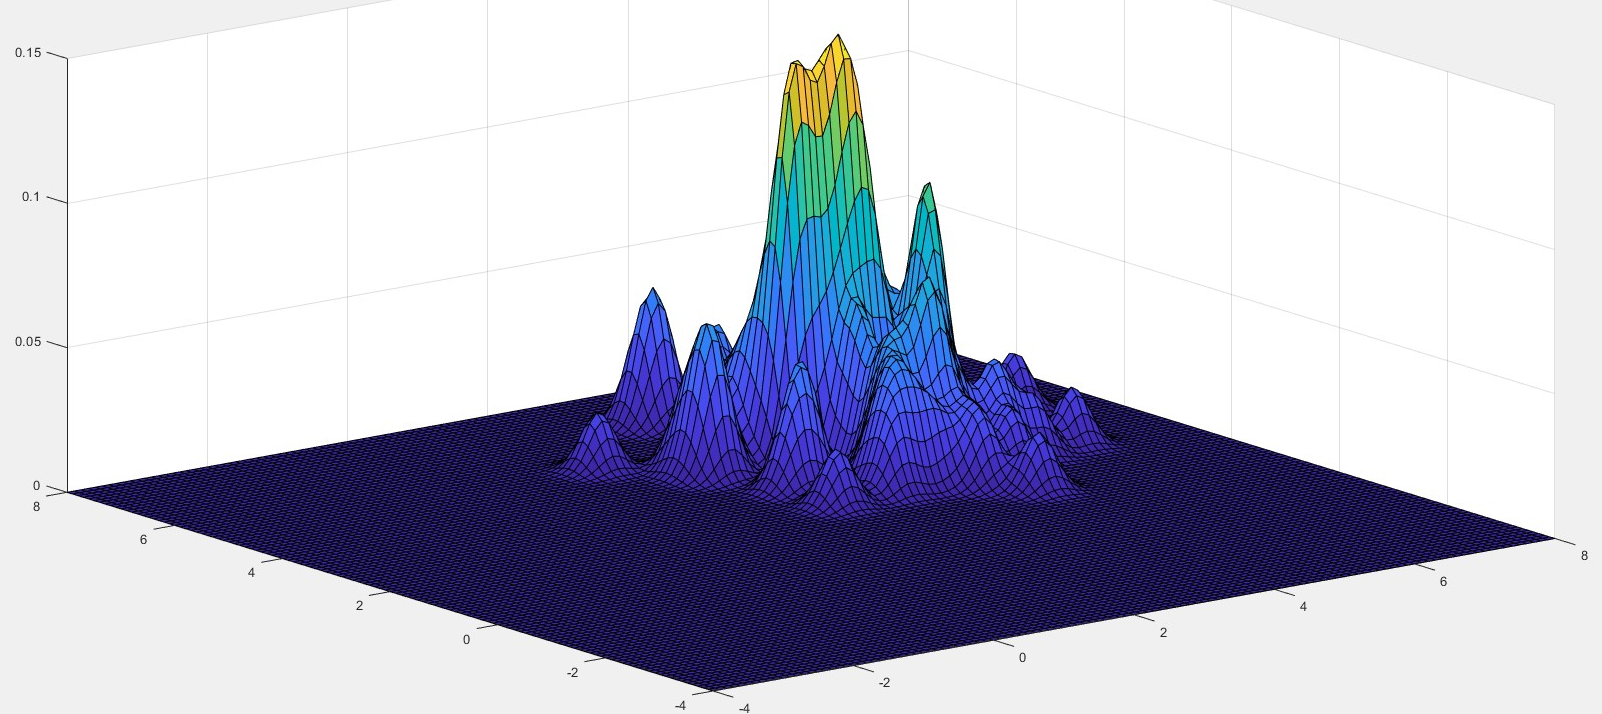

Now we will take the sample point x = [1, -2] and try to classify it based on the estimation.

In [16]:
sample_point = np.array((1, -2))

In [17]:
calc_density(sample_point, hw3_2_1)

0.006164209509999661

In [18]:
calc_density(sample_point, hw3_2_2)

1.40967946891791e-119

Above we can see the two likelihoods for the given sample point. Since the value for Class 1 (0.0062) is much greater than for Class 2 (1.41e-119) we can confidently say this sample belongs to **Class 1**. This makes sense looking at the graphs, as the graph for Class 1 has a much higher peak for the location of the test sample compared to the graph of Class 2

### Part 2

We will now construct a Probabilistic Neural Network (PNN) and use it to classify the same test sample.

First the training samples and test sample need to be normalized, which can be done by dividing each sample by their norm.

In [19]:
from sklearn.preprocessing import normalize

In [20]:
def normalize_weights(x, len_x):
    normalized_weights_list = []
    for i in range(n):
        normalized_weight = x[i] / np.linalg.norm(x[i])
        normalized_weights_list.append(normalized_weight)
    normalized_weights = np.asarray(normalized_weights_list)
    return normalized_weights

The normalized training samples for each class will be the weights that connect the first layer (input) to the second layer (pattern).

In [21]:
normalized_weights_1 = normalize_weights(hw3_2_1.T, n)
normalized_weights_2 = normalize_weights(hw3_2_2.T, n)

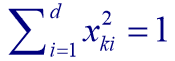

In [22]:
sum(normalized_weights_1[0] ** 2)    # prove they have been normalized

0.9999999999999999

In [23]:
normalized_test_sample = (sample_point / np.linalg.norm(sample_point)).reshape(-1, 1)
normalized_test_sample

array([[ 0.4472136 ],
       [-0.89442719]])

Now that everything has been normalized, we can compute the dot product of the weights with the test sample to obtain the net activation. We do this for both classes. Here we do it in vector form.

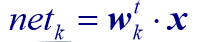

In [24]:
net_activation_vector_1 = normalized_weights_1 @ normalized_test_sample
net_activation_vector_2 = normalized_weights_2 @ normalized_test_sample

Using the net activations we can now obtain the nonlinear active function, which uses the same Gaussian window width (0.2) from the Parzen Window in Part 1. Once again this is done in vector form.

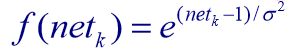

In [25]:
active_function_vector_1 = np.exp((net_activation_vector_1 - 1) / h_n ** 2)
active_function_vector_2 = np.exp((net_activation_vector_2 - 1) / h_n ** 2)

Finally we can sum all of the active function values for each class. This gives us a value for each class. To classify, we choose the class with the highest value.

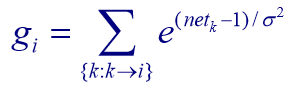

In [26]:
g_1 = sum(active_function_vector_1)
g_2 = sum(active_function_vector_2)
print(g_1)
print(g_2)

[8.90070829]
[1.9525385e-09]


Above we can see the summations g_1 and g_2 for the two classes. Since g_1 is much greater than g_2, we can confidentally classify this test sample as being part of **Class 1**, which matches the classification we got for this test sample in Part 1 with the Parzen Window.